In [1]:
import json
import re 
import copy
import graphviz
import sys
import clingo
import clingo.symbol as symbol
from importlib import reload

In [2]:
# This is a hack to make the library in the parent folder available for imoprts
# A better solution is by np8 here:
# https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder
import sys
import os
import inspect

thisdir = sys.path[0]
print(f"thisdir = {thisdir}")
parentdir = os.path.dirname(thisdir)
#print(f"parentdir = {parentdir}")
if not parentdir in sys.path:
    print("Adding parent directory to python path")
    sys.path.insert(1, parentdir)
else:
    print("Skipping adding parent direct to path (there already)")

print(f"sys.path =\n{sys.path}")


thisdir = /home/luke/git/external/asp_recipe_graphs/notebooks
Adding parent directory to python path
sys.path =
['/home/luke/git/external/asp_recipe_graphs/notebooks', '/home/luke/git/external/asp_recipe_graphs', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/luke/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3.10/dist-packages']


In [3]:
## local modules
os.environ["GRASP_SRC_DIR"] = '..'

import asp_recipe_graphs.api.modules
reload(asp_recipe_graphs.api.modules)

from asp_recipe_graphs.api.modules import MODULES
from asp_recipe_graphs.api.modules import RE_FIND_TERMS
from asp_recipe_graphs.api.modules import RE_IS_DEFINITION
from asp_recipe_graphs.api.modules import ASP_MODULE_DEFINES
from asp_recipe_graphs.api.modules import ASP_MODULE_USES
from asp_recipe_graphs.api.modules import DEPENDENCY_MAP
from asp_recipe_graphs.api.modules import ALL_DEFINED
from asp_recipe_graphs.api.modules import ALL_USES
from asp_recipe_graphs.api.modules import UNDEFINED_TERMS
from asp_recipe_graphs.api.modules import get_dependencies
from asp_recipe_graphs.api.modules import what_defines
from asp_recipe_graphs.api.modules import what_uses

import asp_recipe_graphs.api.asp2graph
reload(asp_recipe_graphs.api.asp2graph)
from asp_recipe_graphs.api.asp2graph import create_dependency_graph

import asp_recipe_graphs.api.solver
reload(asp_recipe_graphs.api.solver)
from asp_recipe_graphs.api.solver import load_and_solve


## Modules

There are a number of asp modules, which define and use terms, and these are subject to change. The python module `asp_recipe_graphs.asp.modules` provides functionality that interrogates these modules and gives information on this. In particular, there is information on which modules define and use which terms, which modules directly depend on other modules, and getting a full dependency chain for a given module or set of modules.

Note that this is not precise. There will be errors in this but at the time of writing there were none detected that interfere with the logic of the solver (see below).

In [4]:
print("Defines:")
for m, defines in ASP_MODULE_DEFINES.items():
    print(f"\t{m} defines {defines}")
# print(f"asp_module_defines = {ASP_MODULE_DEFINES}")
print()
print("Uses")
for m, uses in ASP_MODULE_USES.items():
    print(f"\t{m} uses {uses}")
print()
print(f"undefined_terms = {UNDEFINED_TERMS}")
print()

Defines:
	acceptability defines {'acceptable_recipe', 'acceptability_tuple'}
	composition defines {'composable', 'incompatible_node_types', 'empty_intersection'}
	equivalence defines {'equivalent'}
	granularity defines {'not_same_recipe', 'mapped_to_by_g_function', 'finer_grained', 'more_specific', 'path_or_equal'}
	graph_properties defines {'graph', 'connected_in', 'connected', 'path', 'is_node', 'cyclic', 'has_outgoing_arc', 'has_incoming_arc'}
	in_out_aligned defines {'in_out_aligned'}
	isomorphisms defines {'isomorphic'}
	debug_recipes defines {'has_untyped_node', 'conflicting_types'}
	recipe_graphs defines {'atomic_recipe', 'graph', 'type_function', 'high_indexes_allowed', 'given_recipe_graph', 'subrecipe_graph_of', 'recipe_graph', 'recipe', 'strict_subrecipe_graph', 'atomic_recipe_graph', 'typed_graph'}
	subrecipes defines {'subrecipe_of'}
	type_hierarchies defines {'action_type', 'subtype', 'action_or_comestible_type', 'same_type_path', 'subtype_or_equal', 'comestible_type'}
	un

In [5]:
# MODULES tells us what modules are defined (domain independent)
MODULES

['acceptability',
 'composition',
 'equivalence',
 'granularity',
 'graph_properties',
 'in_out_aligned',
 'isomorphisms',
 'debug_recipes',
 'recipe_graphs',
 'subrecipes',
 'type_hierarchies',
 'universal_types']

In [6]:
# all terms that have been defined in at least one module,
print(f"ALL_DEFINED = {ALL_DEFINED}", end='\n\n')
# all terms that are used in at least one module
print(f"ALL_USES = {ALL_USES}", end='\n\n')
# all terms that are used but not defined
print(f"UNDEFINED_TERMS = {UNDEFINED_TERMS}")


ALL_DEFINED = {'has_untyped_node', 'composable', 'graph', 'incompatible_node_types', 'empty_intersection', 'connected_in', 'equivalent', 'same_type_path', 'connected', 'path', 'is_node', 'more_specific', 'isomorphic', 'conflicting_types', 'recipe', 'has_outgoing_arc', 'atomic_recipe_graph', 'type_function', 'mapped_to_by_g_function', 'in_out_aligned', 'finer_grained', 'cyclic', 'subrecipe_graph_of', 'recipe_graph', 'atomic_recipe', 'not_same_recipe', 'subtype', 'action_or_comestible_type', 'high_indexes_allowed', 'subtype_or_equal', 'given_recipe_graph', 'strict_subrecipe_graph', 'comestible_type', 'typed_graph', 'action_type', 'subrecipe_of', 'child', 'path_or_equal', 'has_incoming_arc', 'acceptable_recipe', 'acceptability_tuple'}

ALL_USES = {'arcs', 'int', 'set_of', 'empty', 'same_type_path', 'connected', 'path', 'partial_inset_with_size', 'type_of', 'composition', 'recipe', 'isomorphic', 'is_a_node', 'acts', 'input_set', 'partial_outset', 's_', 'bijection', 'recipe_graph', 'cyclic'

In [17]:
# what_defines(...) asks what module defines a given term 
# (if more than one module defines a term it returns the first module detected)
what_defines('high_indexes_allowed')

'recipe_graphs'

In [16]:
# what_uses(...) asks what modules use a given term.
what_uses('high_indexes_allowed')

[]

In [9]:
# DEPENDENCY_MAP map shows the direct dependencies between modules. 
print(f"dependency_map = {DEPENDENCY_MAP}")

dependency_map = {'acceptability': {'recipe_graphs'}, 'composition': {'recipe_graphs', 'type_hierarchies'}, 'equivalence': {'recipe_graphs', 'isomorphisms'}, 'granularity': {'graph_properties', 'recipe_graphs', 'type_hierarchies', 'in_out_aligned', 'isomorphisms'}, 'graph_properties': set(), 'in_out_aligned': {'recipe_graphs'}, 'isomorphisms': {'recipe_graphs'}, 'debug_recipes': {'recipe_graphs', 'type_hierarchies'}, 'recipe_graphs': {'graph_properties', 'type_hierarchies'}, 'subrecipes': {'recipe_graphs'}, 'type_hierarchies': {'universal_types'}, 'universal_types': set()}


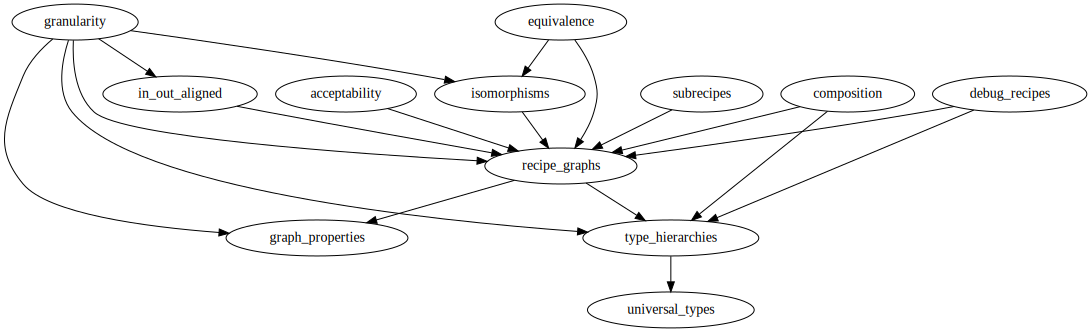

In [10]:
# def create_dependency_graph(dependency_map):
#     dot = graphviz.Digraph()
#     node_ids = {}
#     for i,k in enumerate(dependency_map.keys()):
#         print(f"i,k : {i,k}")
#         node_ids[k] = 'n'+str(i)
# #         dot.node(i, label=k, style='filled', color='yellow', shape='box')
#         dot.node(k, label=k)
#     for source, targets in dependency_map.items():
# #         sid = node_ids[source]
#         for target in targets:
# #             tid = node_ids[target]
#             dot.edge(source,target)
#     return dot
# create_dependency_graph creates a graph of the module dependencies
create_dependency_graph(DEPENDENCY_MAP)

In [11]:
# get_dependencies(...) resolves the full chain of dependencies for one or more modules.
specified = ['acceptability']
get_dependencies(specified)


{'acceptability',
 'graph_properties',
 'recipe_graphs',
 'type_hierarchies',
 'universal_types'}

# Running ASP

In [12]:
fpaths =[]
fpaths.append('../asp_recipe_graphs/asp/recipes/hummus_graph.lp')
fpaths.append('../asp_recipe_graphs/asp/recipes/hummus_types.lp')
# fpaths.append('../asp_recipe_graphs/asp/recipes/cannellini_hummus_graph.lp')
# fpaths.append('../asp_recipe_graphs/asp/recipes/cannellini_hummus_types.lp')
# fpaths.append('../asp_recipe_graphs/asp/recipes/edamame_hummus_graph.lp')
# fpaths.append('../asp_recipe_graphs/asp/recipes/edamame_hummus_types.lp')
# fpaths.append('../asp_recipe_graphs/asp/recipes/baba_ganoush_graph.lp')
# fpaths.append('../asp_recipe_graphs/asp/recipes/baba_ganoush_types.lp')
#models = load_and_solve('connected', fpaths)    
#models = load_and_solve('cyclic', fpaths)    
#models = load_and_solve('arcs',fpaths)       
#models = load_and_solve('types',fpaths)
#models = load_and_solve('arcs and types',fpaths)          
# models = load_and_solve('recipe_graph',fpaths[:1], additional_asp="""
#     -recipe_graph(rg_cannellini_hummus).
#     """)          
# models = load_and_solve('recipe_graph',fpaths[:1], additional_asp="""
#     -recipe_graph(rg_cannellini_hummus).
#     """)          
# models = load_and_solve('recipe_graph',fpaths[:1])
#models = load_and_solve('explain not recipe_graph',fpaths[:1])          
# models = load_and_solve('explain not recipe',fpaths[:1])          
# models = load_and_solve('recipes',fpaths)
# models = load_and_solve('conflicting types',fpaths)
# models = load_and_solve('is recipe',fpaths)
models = load_and_solve('untyped nodes',fpaths)          
models

loading...
fpath =../asp_recipe_graphs/asp/domain_independent/universal_types.lp
fpath =../asp_recipe_graphs/asp/domain_independent/graph_properties.lp
fpath =../asp_recipe_graphs/asp/domain_independent/recipe_graphs.lp
fpath =../asp_recipe_graphs/asp/domain_independent/type_hierarchies.lp
fpath =../asp_recipe_graphs/asp/domain_independent/debug_recipes.lp
fpath =../asp_recipe_graphs/asp/recipes/hummus_graph.lp
fpath =../asp_recipe_graphs/asp/recipes/hummus_types.lp


['in(arcs(rg_hummus),arc(c(0),a(0))) in(arcs(rg_hummus),arc(a(0),c(6))) in(arcs(rg_hummus),arc(c(1),a(1))) in(arcs(rg_hummus),arc(c(2),a(1))) in(arcs(rg_hummus),arc(c(3),a(1))) in(arcs(rg_hummus),arc(c(4),a(1))) in(arcs(rg_hummus),arc(c(5),a(1))) in(arcs(rg_hummus),arc(c(6),a(1))) in(arcs(rg_hummus),arc(a(1),c(8))) in(arcs(rg_hummus),arc(c(7),a(2))) in(arcs(rg_hummus),arc(a(2),c(9))) in(arcs(rg_hummus),arc(c(8),a(3))) in(arcs(rg_hummus),arc(c(9),a(3))) in(arcs(rg_hummus),arc(a(3),c(10))) in(a_nodes(rg_hummus),a(0)) in(a_nodes(rg_hummus),a(1)) in(a_nodes(rg_hummus),a(2)) in(a_nodes(rg_hummus),a(3)) in(nodes(rg_hummus),a(0)) in(nodes(rg_hummus),a(1)) in(nodes(rg_hummus),a(2)) in(nodes(rg_hummus),a(3)) in(c_nodes(rg_hummus),c(0)) in(c_nodes(rg_hummus),c(1)) in(c_nodes(rg_hummus),c(2)) in(c_nodes(rg_hummus),c(3)) in(c_nodes(rg_hummus),c(4)) in(c_nodes(rg_hummus),c(5)) in(c_nodes(rg_hummus),c(6)) in(c_nodes(rg_hummus),c(7)) in(c_nodes(rg_hummus),c(8)) in(c_nodes(rg_hummus),c(9)) in(c_nodes(

In [13]:
models = load_and_solve('untyped nodes', fpaths)

facts ={}
pold = None
for t in models[0].split(') '):    
    p = t.split('(')[0]
    if p != pold:
        print(p+':')
        pold = p
        facts[p] = []
    facts[p].append(t)
    print(f"\t{t})")

loading...
fpath =../asp_recipe_graphs/asp/domain_independent/universal_types.lp
fpath =../asp_recipe_graphs/asp/domain_independent/graph_properties.lp
fpath =../asp_recipe_graphs/asp/domain_independent/recipe_graphs.lp
fpath =../asp_recipe_graphs/asp/domain_independent/type_hierarchies.lp
fpath =../asp_recipe_graphs/asp/domain_independent/debug_recipes.lp
fpath =../asp_recipe_graphs/asp/recipes/hummus_graph.lp
fpath =../asp_recipe_graphs/asp/recipes/hummus_types.lp
in:
	in(arcs(rg_hummus),arc(c(0),a(0)))
	in(arcs(rg_hummus),arc(a(0),c(6)))
	in(arcs(rg_hummus),arc(c(1),a(1)))
	in(arcs(rg_hummus),arc(c(2),a(1)))
	in(arcs(rg_hummus),arc(c(3),a(1)))
	in(arcs(rg_hummus),arc(c(4),a(1)))
	in(arcs(rg_hummus),arc(c(5),a(1)))
	in(arcs(rg_hummus),arc(c(6),a(1)))
	in(arcs(rg_hummus),arc(a(1),c(8)))
	in(arcs(rg_hummus),arc(c(7),a(2)))
	in(arcs(rg_hummus),arc(a(2),c(9)))
	in(arcs(rg_hummus),arc(c(8),a(3)))
	in(arcs(rg_hummus),arc(c(9),a(3)))
	in(arcs(rg_hummus),arc(a(3),c(10)))
	in(a_nodes(rg_hummu

In [14]:
print(f"facts.get('-well_typed_a_node') = {facts.get('-well_typed_a_node')}", end='\n\n')
print(f"facts.get('-well_typed_c_node') = {facts.get('-well_typed_c_node')}", end='\n\n')
print(f"facts.get('type_of') = {facts.get('type_of')}", end='\n\n')
print(f"facts.get('conflicting_types') = {facts.get('conflicting_types')}", end='\n\n')
# print(f"facts['comestible_type'] ={facts['comestible_type']}", end='\n\n')

facts.get('-well_typed_a_node') = None

facts.get('-well_typed_c_node') = None

facts.get('type_of') = ['type_of(tf_hummus,c(0),"whole garlic"', 'type_of(tf_hummus,c(1),"tahini"', 'type_of(tf_hummus,c(2),"salt"', 'type_of(tf_hummus,c(3),"lemon juice"', 'type_of(tf_hummus,c(4),"olive oil"', 'type_of(tf_hummus,c(5),"water"', 'type_of(tf_hummus,c(6),"diced garlic"', 'type_of(tf_hummus,c(7),"tinned chick peas"', 'type_of(tf_hummus,c(8),"mixture of garlic, tahini, salt, lemon juice, olive oil and water"', 'type_of(tf_hummus,c(9),"rinsed chick peas"', 'type_of(tf_hummus,c(10),"hummus"', 'type_of(tf_hummus,a(0),"dice"', 'type_of(tf_hummus,a(1),"blend until uniform"', 'type_of(tf_hummus,a(2),"rinse and drain"', 'type_of(tf_hummus,a(3),"blend together"']

facts.get('conflicting_types') = None



In [15]:
raise ValueError('Stop!')

ValueError: Stop!

## Older code

In [ ]:

lp_fnames = ["GraphRecipes.lp","ScratchExample.lp"]
lp_fnames = ["GraphRecipes.lp","SnacksOnToastExample.lp"]

In [ ]:
ctl = clingo.Control()
for lp_fname in lp_fnames:
    ctl.load(lp_fname)
ctl.ground([("base", [])])
#answer_sets = []
result = ctl.solve(on_model=lambda m: print("Answer: {}".format(m)))

In [ ]:
ctl = clingo.Control()
for lp_fname in lp_fnames:
    ctl.load(lp_fname)
ctl.ground([("base", [])])
models = []
with ctl.solve(yield_=True) as handle:
    for model in handle:
        models.append(model.symbols(shown=True))
models

In [ ]:
for atom in models[0]:
    print(f"atom.type = {atom.type}")
    if atom.type == symbol.SymbolType.Function:
        print(f"atom.name = {atom.name}")
        print(f"atom.arguments = {atom.arguments}")
        print(f"str(atom) = {str(atom)}")
        #print(f"atom.negative = {atom.negative}")
        #print(f"atom.number = {atom.number}")
        #print(f"atom.positive = {atom.positive}")
        #print(f"atom.string = {atom.string}")
